# Allen-Cahn equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *

### Setup

In [26]:
# Exact solution (from MATLAB)

# import numpy as np
# from scipy.interpolate import interp2d

# def exactAC(x, t):
#     solution_matlab = np.genfromtxt("ac_ref.txt", delimiter=",") # format: [t, u]
#     timesteps = solution_matlab[:, 0]
#     solution = solution_matlab[:, 1:]
#     # MATLAB grid: N = 2048, adaptive dt
#     interpolator = interp2d(timesteps, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 2048), solution.T, kind='linear', fill_value='extrapolate')
#     return interpolator(t.squeeze(), x.squeeze())

In [83]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp2d

def exactAC():
    
    N = 1024
    x = np.linspace(0, 2 * np.pi, N)
    L = 2 * np.pi
    h = L / N
    T = 4
    
    epsilon = 5e-2
    a = lambda x, t: (1.05 + t * np.sin(x))
    phi = lambda x, w, b: np.exp(- w ** 2 * np.abs(np.sin(np.pi * (x - b) / (2 * np.pi))) ** 2)
    u0 = phi(x, np.sqrt(10), 0.5) - phi(x, np.sqrt(10), 4.4)
    
    A = - 2 * np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)
    # periodic boundary conditions
    A[0, 0], A[0, 1], A[0, -1] = 0, 0, h ** 2
    A[-1, -1], A[-1, -2], A[-1, 0] = 0, 0, h ** 2
    
    rhs = lambda t, u: epsilon * A @ u / (h ** 2) - a(x, t) * (u - u ** 3)
    
    res = solve_ivp(rhs, [0, T], u0, method='BDF')
    
    return res.t, res.y # t, u

In [81]:
timesteps_ref, solution_ref = exactAC()

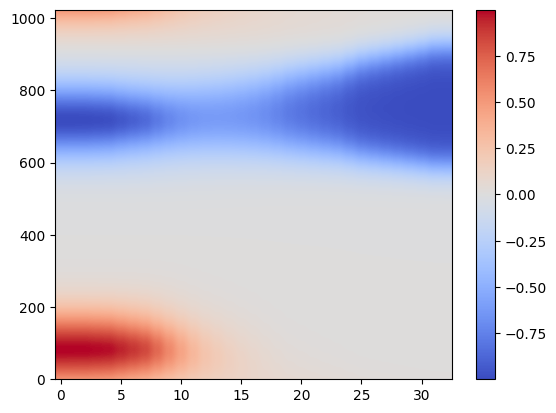

In [82]:
plt.imshow(solution_ref, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [105]:
def exactAC_eval(x, t):
    interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
    return interpolator(t.squeeze(), x.squeeze())

In [106]:
# Problem and training data

phi = lambda x, w, b: jnp.exp(- w ** 2 * jnp.abs(jnp.sin(jnp.pi * (x - b) / (2 * jnp.pi))) ** 2)
u0 = lambda x: phi(x, jnp.sqrt(10), 0.5) - phi(x, jnp.sqrt(10), 4.4)

problem_data = ProblemData(name='ac', # problem name
                           d=1, # input dimension
                           domain=(0, 2 * jnp.pi), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=u0, # initial condition
                           exact_sol=exactAC_eval, # exact solution
                           N=2048, # number of spatial points
                           dt=0.01, # time step
                          )

training_data = TrainingData(m=2, # number of neurons per layer
                             l=3, # number of layers
                             batch_size=1000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.75) # learning rate scheduler (m = 2, l = 3)
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler (m = 10, l = 1)
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                             #scheduler=optax.cosine_decay_schedule(init_value=0.1, decay_steps=1000) # learning rate scheduler
                            )

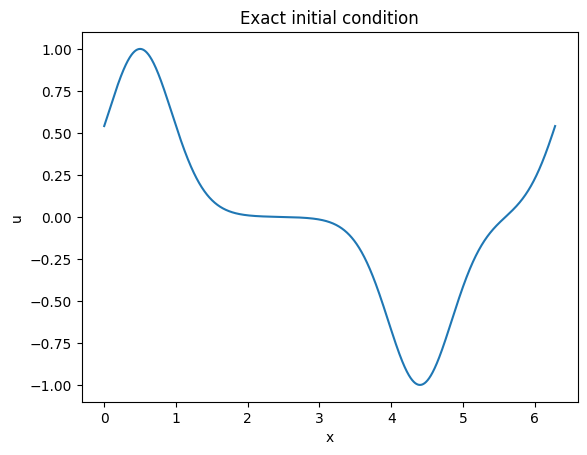

In [86]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [6]:
print(problem_data)

Problem data:
  name: ac, d: 1, domain: (0, 6.283185307179586), T: 4, N: 2048, dt: 0.01


In [7]:
print(training_data)

Training data:
  m: 2, l: 3, batch size: 1000, epochs: 10000, gamma: 0.1, seed: 0, scheduler: <function exponential_decay.<locals>.schedule at 0x7f4f283b37e0>


### Initial fit

In [87]:
# Neural network

net = DeepNetAC(training_data.m, training_data.l, problem_data.domain[1] - problem_data.domain[0])
print(net)

DeepNetAC(
    # attributes
    m = 2
    l = 3
    L = 6.283185307179586
)


In [88]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N).reshape(-1, 1)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - u0(x_plot)) / jnp.linalg.norm(u0(x_plot))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.0062920586


### Time evolution

In [89]:
# Source term for the AC equation

def rhs_ac(theta_flat, x, t, u_fn):
    epsilon = 5e-2
    a = lambda x, t: (1.05 + t * jnp.sin(x)).squeeze()
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_ddx = jax.vmap(gradsqz(gradsqz(u_fn, 1), 1), (None, 0))
    u = U(theta_flat, x)
    u_xx = U_ddx(theta_flat, x)
    return epsilon * u_xx - a(x, t) * (u - u ** 3)

In [90]:
# @jax.jit
# def r_loss(theta_flat, theta_flat_k, x, t):
#     '''
#     Compute the norm of the residual.
#     '''
#     return jnp.linalg.norm(r_fn(theta_flat, theta_flat_k, x, t))

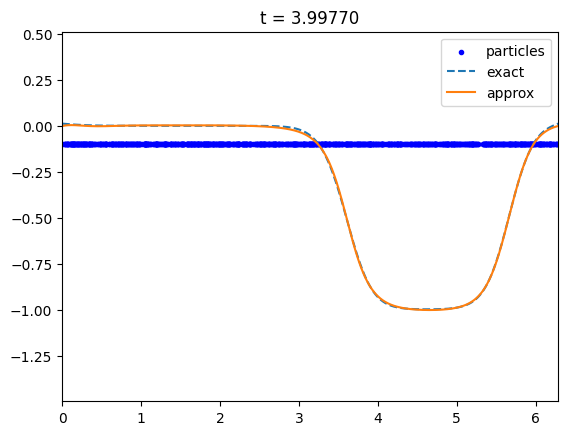

In [107]:
solution, timesteps, _ = neural_galerkin(theta=theta, # initial parameters
                                         net=net, # neural network
                                         problem_data=problem_data, # problem data
                                         n=1000, # sample points
                                         rhs=rhs_ac, # problem RHS
                                         x_init=None,
                                         sampler='uniform',
                                         scheme='rk45' # 'bwe'
                                        )

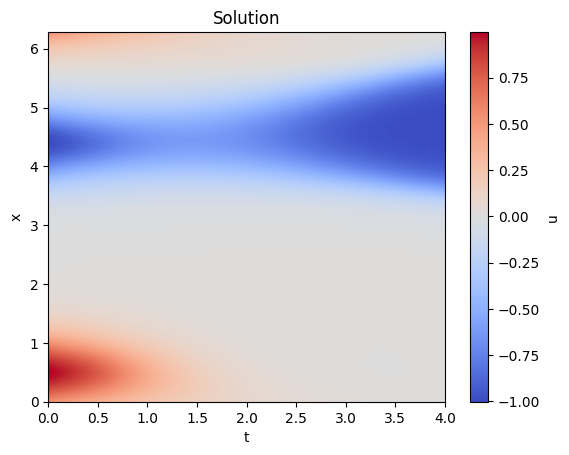

In [108]:
plot_solution(solution, timesteps, problem_data)

In [17]:
# plot_animation(solution, timesteps, problem_data)

### Compute relative error

In [109]:
errors = compute_error(solution, timesteps, exactAC_eval, problem_data)

/tmp/ipykernel_1095/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_1095/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, fo

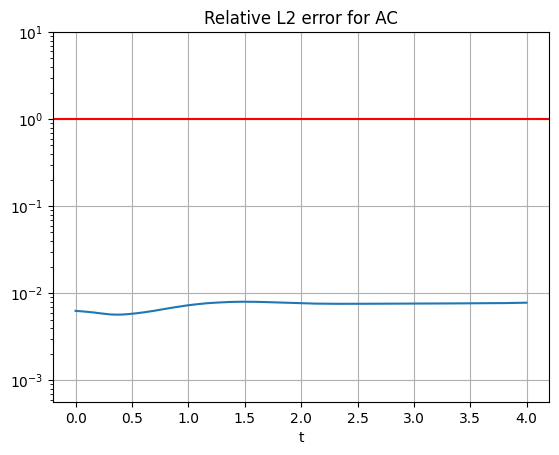

In [110]:
plot_error(errors, timesteps, 'Relative L2 error for AC')

### Comparison with Neural Galerkin with adaptive measure

In [34]:
# Accept-reject to sample from the initial condition (absolute value)

from scipy.stats import norm, uniform
from numpy import random

def init_samples_ac(n, max_it=1000, seed=0):

    random.seed(seed) # set seed for reproducibility

    def ACWrapper(x):
        return np.abs(problem_data.initial_fn(x))

    # Proposal distribution: gaussian mixture
    g1 = norm(loc=0.5, scale=0.6)
    g2 = norm(loc=4.4, scale=0.6)
    g3 = norm(loc=6.8, scale=0.6)
    C = 1 # scaling constant

    x = []

    for _ in range(n):
        it = 0
        while it < max_it:
            idx = random.randint(0, 3)
            u = uniform.rvs() # sample from a uniform in [0, 1]
            if idx == 0:
                g = g1
            elif idx == 1:
                g = g2
            elif idx == 2:
                g = g3
            y = g.rvs()
            if u <= ACWrapper(y) / (C * g.pdf(y)):
                x.append(y)
                break
            it += 1
        if it >= max_it:
            raise Exception("AR did not converge.")

    return jnp.array(x)

In [ ]:
solution_adaptive, timesteps_adaptive, _ = neural_galerkin(theta=theta, # initial parameters
                                                           net=net, # neural network
                                                           problem_data=problem_data, # problem data
                                                           n=10, # sample points
                                                           rhs=rhs_ac, # problem RHS
                                                           x_init=init_samples_ac(10).reshape(-1, 1),
                                                           sampler='svgd',
                                                           scheme='rk45' # 'bwe'
                                                          )

In [ ]:
plot_solution(solution_adaptive, timesteps_adaptive, problem_data)

In [ ]:
errors_adaptive = compute_error(solution_adaptive, timesteps_adaptive, exactAC, problem_data)

In [ ]:
plot_error(errors_adaptive, timesteps_adaptive, 'Relative L2 error for NG with adaptive sampling')

### Conditioning number

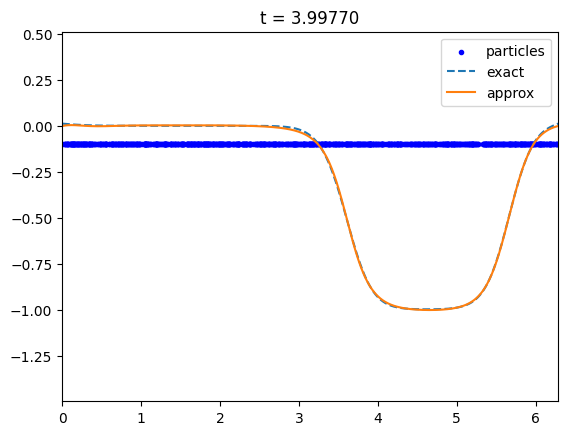

In [111]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_ac, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True # save conditioning number and singular values of the mass matrix
                                                 )

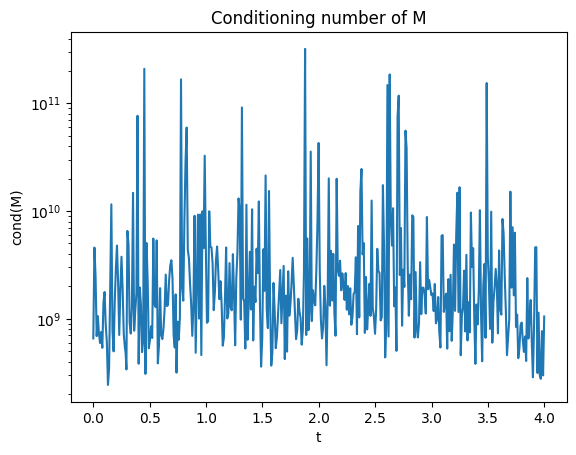

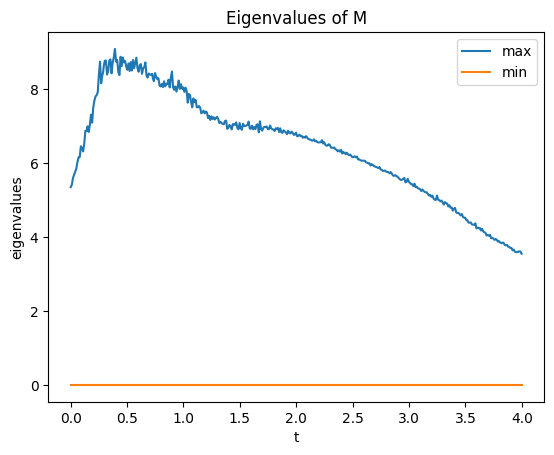

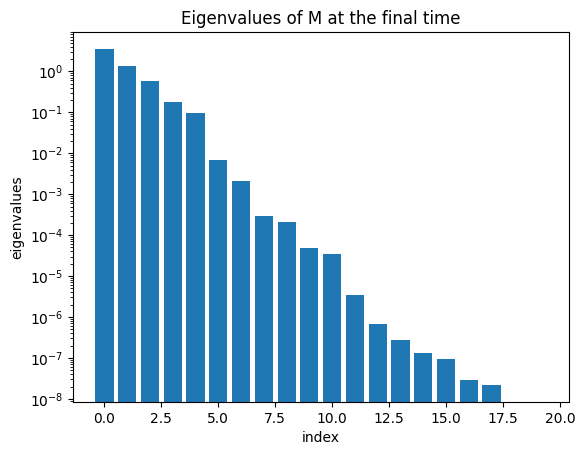

In [112]:
diagnostic.plot(timesteps)